In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.debugger import set_trace
import random
from IPython.display import Image
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import glob
import os.path
import IPython
import random
 

/home/kchow/.conda/envs/SpeechVAE/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# try a dataset, save all spectrograms somewhere
filenames = glob.glob("/home/kchow/datasets/clips/*.mp3")
spectrogram_clips = []
mel_spectrogram_clips = []

restart = False

number_of_clips = 10

# if numpy loaded 
if not restart and os.path.isfile('spec_clips_.npy') and os.path.isfile('mel_spec_clips_.npy'):
    spectrogram_clips = np.load('spec_clips_.npy')
    mel_spectrogram_clips = np.load('mel_spec_clips_.npy')
else:
    for f in filenames:
        print(f)
        y, sr = librosa.load(f)
        D = np.abs(librosa.stft(y))**2
        D = D[:1024,:1939]
        S = librosa.feature.melspectrogram(S=D)
        S = S[:128,:1939]
        if np.shape(D)[0] != 1024 or np.shape(D)[1] != 1939 or np.shape(S)[0] != 128 or np.shape(S)[1] != 1939:
            continue
        spectrogram_clips.append(D)
        mel_spectrogram_clips.append(S)

np.save('spec_clips_.npy', np.array(spectrogram_clips))
np.save('mel_spec_clips_.npy', np.array(mel_spectrogram_clips))


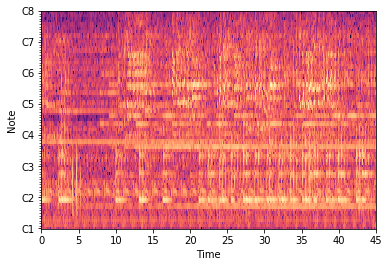

In [9]:
test_file = "/home/kchow/datasets/clips/98.mp3"
y, sr = librosa.load(test_file)
C = np.abs(librosa.cqt(y, sr=sr))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')



In [11]:
np.shape(spectrogram_clips)

(991, 1024, 1939)

In [3]:
len(spectrogram_clips)

991

In [ ]:
# spectrogram is 1025 * 1939, mel spectrogram is 128 * 1939
np.shape(spectrogram_clips[1])

In [15]:
np.shape(spectrogram_clips[:10,:,:])
snip_spectrogram_clips = spectrogram_clips[:10,:,:100]

In [17]:
batch_size = 8
epochs = 100
no_cuda = False
seed = 1
beta = 1
log_interval = 1000
cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
loss_function_type = 'Beta' # [DIP-VAE1, 'DIP-VAE2, Beta']
latent_dimensions = 128
fc_dimensions = 512

In [5]:
torch.manual_seed
device = torch.device("cuda" if cuda else "cpu")

In [33]:
time_steps = 100
freq_filters = 1024
variable = 24
class MusicSnipAE(nn.Module):
    def __init__(self):
        super(MusicSnipAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        
        #self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        #self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        self.fc1 = nn.Linear(256*variable, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*variable)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #set_trace()
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return x
        #return self.mu_i(x), self.var_i(x)
    
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, variable)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [26]:
time_steps = 1939
freq_filters = 1024
class MusicAE(nn.Module):
    def __init__(self):
        super(MusicAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        
        #self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        #self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        self.fc1 = nn.Linear(256*484, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*484)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return x
        #return self.mu_i(x), self.var_i(x)
    
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, 484)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [98]:
time_steps = 1939
freq_filters = 128
class MusicMelAE(nn.Module):
    def __init__(self):
        super(MusicMelAE, self).__init__()
        # in horizontal mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        
        #self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        #self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        self.fc1 = nn.Linear(256*484, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*484)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return x
        #return self.mu_i(x), self.var_i(x)
    
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, 484)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)


In [105]:
time_steps = 1939
freq_filters = 1024
class MusicVAE(nn.Module):
    def __init__(self):
        super(MusicVAE, self).__init__()
        # in verticl mode 
        self.conv1 = nn.Conv1d(1, 64, kernel_size=freq_filters, stride=freq_filters)
        #self.conv1 = nn.Conv1d(1, 64, kernel_size=time_steps, stride=time_steps)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2)
        
        self.mu_i = nn.Linear(fc_dimensions, latent_dimensions)
        self.var_i = nn.Linear(fc_dimensions, latent_dimensions)
        
        self.fc1 = nn.Linear(256*484, fc_dimensions)
        self.fc2 = nn.Linear(latent_dimensions, fc_dimensions)
        self.fc3 = nn.Linear(fc_dimensions, 256*484)
 
        #self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2)
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=3, stride=2) #to get same size, just kernel+1
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=freq_filters, stride=freq_filters)
        #self.deconv3 = nn.ConvTranspose1d(64, 1, kernel_size=time_steps, stride=time_steps)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        return self.mu_i(x), self.var_i(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        z = z.view(z.size(0), 256, 484)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.tanh(self.deconv3(z))
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [117]:
model = MusicVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    if loss_function_type == 'DIP-VAE1':
        return DIP_1_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'DIP-VAE2':
        return DIP_2_loss_function(recon_x, x, mu, logvar)
    elif loss_function_type == 'Beta':
        return beta_loss_function(recon_x, x, mu, logvar)

def beta_loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + (beta*(KLD)/recon_x.size(0))
    

def DIP_1_loss_function(recon_x, x, mu, logvar):
    exp_mu = mu.mean(0)
    # should this mu be on the 0th or 1st axis?
    mu_expand1 = mu.unsqueeze(1)
    mu_expand2 = mu.unsqueeze(2)
    exp_mu_mu_t = (mu_expand1 * mu_expand2).mean(0)
    cov = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    # diag = diagonal matrix returned, diag_part just the diagonal (diagonal)
    diag_part = torch.diagonal(cov) 
    off_diag_part = cov - torch.diag(diag_part)

    regulariser_od = lambda_od * (off_diag_part**2).sum()
    regulariser_d = lambda_d * ((diag_part - 1)**2).sum()
    dip_vae_regulariser = regulariser_d + regulariser_od
    return dip_vae_regulariser + beta_loss_function(recon_x, x, mu, logvar)


def DIP_2_loss_function(recon_x, x, mu, logvar):
    sigma = torch.diag(logvar)
    exp_cov = sigma.mean(0)
    
    exp_mu = mu.mean(0)
    mu_expand1 = mu.unsqueeze(1)
    mu_expand2 = mu.unsqueeze(2)
    exp_mu_mu_t = (mu_expand1 * mu_expand2).mean(0)
    
    cov_exp = exp_mu_mu_t - exp_mu.unsqueeze(0) * exp_mu.unsqueeze(1)
    cov_z = cov_exp + exp_cov
    
    diag_part = torch.diagonal(cov_z)
    off_diag_part = cov_z - torch.diag(diag_part)
    
    regulariser_od = lambda_od * (off_diag_part**2).sum()
    regulariser_d = lambda_d * ((diag_part - 1)**2).sum()
    dip_vae_regulariser = regulariser_d + regulariser_od
    return dip_vae_regulariser + beta_loss_function(recon_x, x, mu, logvar)
# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
average_losses = []
def train(epoch):
    model.train()
    train_loss = 0
    subset_data = spectrogram_clips[8:16]
    import random
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)# /data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

    
    
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

In [100]:
model = MusicMelAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = mel_spectrogram_clips[:100]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

In [46]:
model = MusicSnipAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3)
average_losses = []

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x)
    return MSE 

# code from https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def data_batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def train(epoch):
    model.train()
    train_loss = 0
    subset_data = snip_spectrogram_clips[:1]
    random.shuffle(subset_data)
    # shuffle subset
    for data in data_batch(subset_data, batch_size):
        # update this to use a larger batch size 
        data = np.array(data)
        # data columns not consistent
        #data = data[:freq_filters,:time_steps]
        #if np.shape(data)[0] != freq_filters or np.shape(data)[1] != time_steps:
            #continue
        data = torch.from_numpy(data)
        #set_trace()
        # how data is set up here MATTERS. Double check with patrick 
        #set_trace()
        data = torch.transpose(data, 1, 2)
        data = data.contiguous().view(data.size(0), -1, freq_filters*time_steps)
        data = data.to(device, dtype=torch.float)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data) #/data.size(0)
        loss.backward()
        #use clip here 
        #clip_gradient = 2
        #nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        #set_trace()
        train_loss += loss.item()
        optimizer.step()
        print(epoch, loss.item())
    average_loss = train_loss #/ len(subset_data)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))#len(mel_spectrogram_clips)))
    average_losses.append(average_loss)

def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    

1 11093.9560547
====> Epoch: 1 Average loss: 11093.9561
2 11093.9199219
====> Epoch: 2 Average loss: 11093.9199
3 11093.8164062
====> Epoch: 3 Average loss: 11093.8164
4 11093.5625
====> Epoch: 4 Average loss: 11093.5625
5 11093.0058594
====> Epoch: 5 Average loss: 11093.0059
6 11091.9228516
====> Epoch: 6 Average loss: 11091.9229
7 11090.0703125
====> Epoch: 7 Average loss: 11090.0703
8 11087.4648438
====> Epoch: 8 Average loss: 11087.4648
9 11084.9179688
====> Epoch: 9 Average loss: 11084.9180
10 11083.5898438
====> Epoch: 10 Average loss: 11083.5898
11 11083.2529297
====> Epoch: 11 Average loss: 11083.2529
12 11083.1816406
====> Epoch: 12 Average loss: 11083.1816
13 11083.1601562
====> Epoch: 13 Average loss: 11083.1602
14 11083.1533203
====> Epoch: 14 Average loss: 11083.1533
15 11083.1660156
====> Epoch: 15 Average loss: 11083.1660
16 11083.1640625
====> Epoch: 16 Average loss: 11083.1641
17 11083.1552734
====> Epoch: 17 Average loss: 11083.1553
18 11083.1650391
====> Epoch: 18 Av

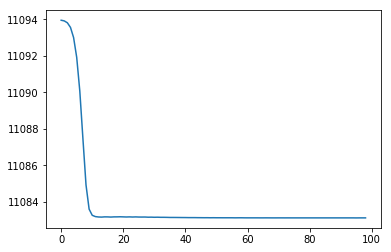

"\nsave_checkpoint({\n        'epoch': epoch + 1,\n        'state_dict': model.state_dict(),\n        'optimizer' : optimizer.state_dict(),\n    }, filename='higherlatentvariableepoch' + str(epoch+1))\n    #test(epoch)\n"

In [47]:
for epoch in range(1, 100):
    train(epoch)
plt.figure(1)
plt.plot(average_losses)
plt.show()
"""
save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),
    }, filename='higherlatentvariableepoch' + str(epoch+1))
    #test(epoch)
"""



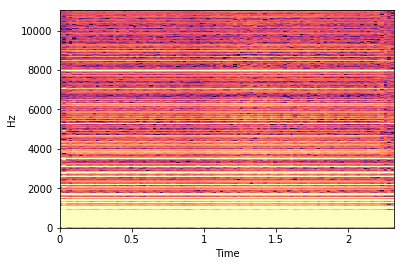

In [48]:
# AE
# reconstruct signal and see how it looks. 
with torch.no_grad():
    sample = snip_spectrogram_clips[0]
    sample = torch.from_numpy(sample)
    sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, -1, freq_filters*time_steps)
    sample = sample.to(device, dtype=torch.float)
    z = model.encode(sample)
    sample = model.decode(z).cpu()
    sample = sample.view(1, time_steps, freq_filters)
    sample = torch.transpose(sample, 1, 2)
    fft_size = 512
    step_size = 64
    #test_sample = mel_to_spectrogram(gogo, get_filterbanks(), 4, 10)
    #recovered_audio_orig = invert_pretty_spectrogram(sample[0], fft_size = fft_size, step_size = step_size, log = True, n_iter = 10)
    
    #import IPython
    
    librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), y_axis='linear', x_axis='time')
    #librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='linear', fmax=8000, x_axis='time')
    #librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), y_axis='linear', x_axis='time')
#y_out = librosa.istft(sample[0].numpy, length=993048)
#IPython.display.Audio(data=y_out, rate=22050)


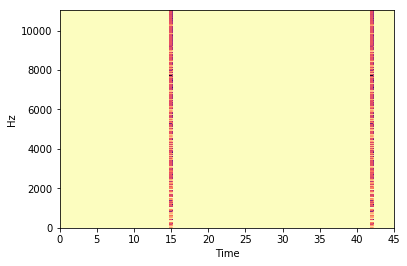

In [116]:

# reconstruct signal and see how it looks. 
with torch.no_grad():
    sample = spectrogram_clips[0]
    sample = torch.from_numpy(sample)
    sample = torch.transpose(sample, 0, 1)
    sample = sample.contiguous().view(1, -1, freq_filters*time_steps)
    sample = sample.to(device, dtype=torch.float)
    mu, logvar = model.encode(sample)
    z = model.reparameterize(mu, logvar)
    #sample = torch.randn(1, latent_dimensions).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(1, time_steps, freq_filters)
    sample = torch.transpose(sample, 1, 2)
    fft_size = 512
    step_size = 64
    #test_sample = mel_to_spectrogram(gogo, get_filterbanks(), 4, 10)
    #recovered_audio_orig = invert_pretty_spectrogram(sample[0], fft_size = fft_size, step_size = step_size, log = True, n_iter = 10)
    
    #import IPython
    
    #librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    #librosa.display.specshow(librosa.power_to_db(sample[0], ref=np.max), y_axis='linear', fmax=8000, x_axis='time')
    librosa.display.specshow(librosa.amplitude_to_db(sample[0], ref=np.max), y_axis='linear', x_axis='time')
y_out = librosa.istft(sample[0].numpy(), length=993048)
IPython.display.Audio(data=y_out, rate=22050)


In [120]:
y_out = librosa.istft(spectrogram_clips[10], length=993048)
##librosa.display.specshow(librosa.amplitude_to_db(spectrogram_clips[0], ref=np.max), y_axis='linear', x_axis='time')
IPython.display.Audio(data=y_out, rate=22050)

In [122]:
np.shape(spectrogram_clips[10])

(1024, 1939)

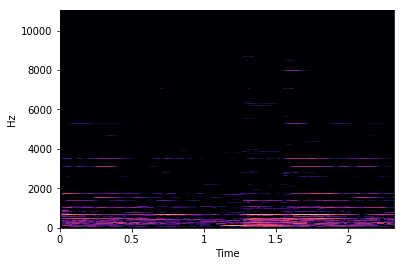

In [49]:
librosa.display.specshow(librosa.amplitude_to_db(snip_spectrogram_clips[0], ref=np.max), y_axis='linear', x_axis='time')

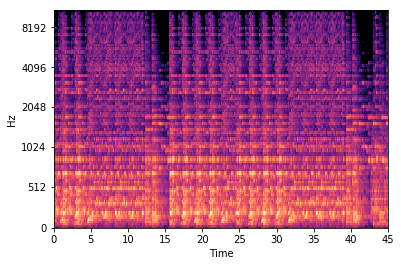

In [55]:
librosa.display.specshow(librosa.power_to_db(mel_spectrogram_clips[0], ref=np.max), y_axis='mel', x_axis='time')

In [ ]:
#librosa.display.specshow(librosa.power_to_db(mel_spectrogram_clips[499], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
IPython.display.Audio(data=y_out, rate=22050)    

In [90]:
# Playing music querying
import IPython
IPython.display.Audio("/home/kchow/SpeechVAE/data/lisa/data/timit/raw/TIMIT/TRAIN/DR1/FCJF0/SA1.PHN")


In [93]:
#CQT regenerate with WaveNet